<a href="https://colab.research.google.com/github/Kh-Harakeh/Thomas-vs-Gauss-Jordan/blob/main/Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

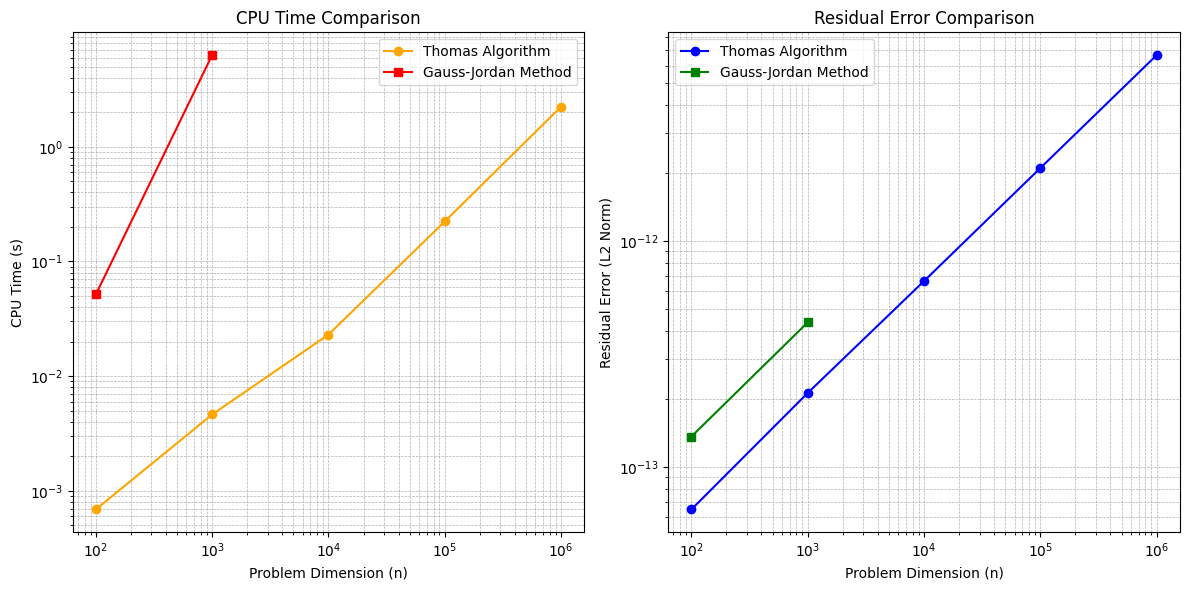

In [11]:
import numpy as np
from scipy.sparse import diags
import time
import matplotlib.pyplot as plt

# Generate a random tridiagonal system
def generate_uniform_tridiagonal_system(n, seed=0):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, size=n-1)  # Sub-diagonal
    c = np.random.uniform(1, 10, size=n-1)  # Super-diagonal
    b = 10 + np.abs(np.append(a, 0)) + np.abs(np.append(0, c))  # Main diagonal ensuring diagonal dominance
    d = np.random.uniform(1, 100, size=n)   # Right-hand side
    return a, b, c, d


# Gauss-Jordan elimination
def gauss_jordan(A, b, precision_threshold=1e-12):
    n = len(b)
    augmented_matrix = np.hstack((A, b.reshape(-1, 1)))

    for i in range(n):
        pivot = augmented_matrix[i, i]
        if abs(pivot) < precision_threshold:
            raise ValueError(f"Matrix is singular or nearly singular at row {i}. Pivot: {pivot}")

        augmented_matrix[i] /= pivot

        for j in range(n):
            if i != j:
                factor = augmented_matrix[j, i]
                augmented_matrix[j] -= factor * augmented_matrix[i]

    return augmented_matrix[:, -1]

# Thomas Algorithm
def thomas_algorithm(a, b, c, d, precision_threshold=1e-12):
    n = len(d)
    c_prime = np.zeros(n-1, dtype=np.float64)
    d_prime = np.zeros(n, dtype=np.float64)

    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]

    for i in range(1, n):
        denominator = b[i] - a[i - 1] * c_prime[i - 1]
        if abs(denominator) < precision_threshold:
            raise ValueError("Matrix is singular or nearly singular.")
        if i < n - 1:
            c_prime[i] = c[i] / denominator
        d_prime[i] = (d[i] - a[i - 1] * d_prime[i - 1]) / denominator

    x = np.zeros(n, dtype=np.float64)
    x[-1] = d_prime[-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i + 1]

    return x

def main():
    dimensions_thomas = [10**2, 10**3, 10**4, 10**5, 10**6]
    dimensions_gauss_jordan = [10**2, 10**3]

    cpu_times_thomas = []
    cpu_times_gauss_jordan = []
    residual_errors_thomas = []
    residual_errors_gauss_jordan = []

    # Benchmark Thomas Algorithm
    for dimension in dimensions_thomas:
        a, b, c, d = generate_uniform_tridiagonal_system(dimension)
        start_time = time.time()
        try:
            x_thomas = thomas_algorithm(a, b, c, d)
            residual_thomas = np.linalg.norm(diags([a, b, c], [-1, 0, 1]).dot(x_thomas) - d)
            residual_errors_thomas.append(residual_thomas)
        except ValueError:
            print(f"Thomas Algorithm failed for dimension {dimension}")
            residual_errors_thomas.append(np.nan)
        cpu_times_thomas.append(time.time() - start_time)

    # Benchmark Gauss-Jordan Algorithm
    for dimension in dimensions_gauss_jordan:
        a, b, c, d = generate_uniform_tridiagonal_system(dimension)
        A = diags([a, b, c], [-1, 0, 1]).toarray()
        start_time = time.time()
        try:
            x_gauss_jordan = gauss_jordan(A, d)
            residual_gauss_jordan = np.linalg.norm(A @ x_gauss_jordan - d)
            residual_errors_gauss_jordan.append(residual_gauss_jordan)
        except ValueError:
            print(f"Gauss-Jordan method failed for dimension {dimension}")
            residual_errors_gauss_jordan.append(np.nan)
        cpu_times_gauss_jordan.append(time.time() - start_time)

    # Plotting
    plt.figure(figsize=(12, 6))

    # CPU Time Comparison
    plt.subplot(1, 2, 1)
    plt.plot(dimensions_thomas, cpu_times_thomas, marker='o', color='orange', label='Thomas Algorithm')
    plt.plot(dimensions_gauss_jordan, cpu_times_gauss_jordan, marker='s', color='red', label='Gauss-Jordan Method')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Problem Dimension (n)')
    plt.ylabel('CPU Time (s)')
    plt.title('CPU Time Comparison')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    # Residual Error Comparison
    plt.subplot(1, 2, 2)
    plt.plot(dimensions_thomas, residual_errors_thomas, marker='o', color='blue', label='Thomas Algorithm')
    plt.plot(dimensions_gauss_jordan, residual_errors_gauss_jordan, marker='s', color='green', label='Gauss-Jordan Method')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Problem Dimension (n)')
    plt.ylabel('Residual Error (L2 Norm)')
    plt.title('Residual Error Comparison')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)

    plt.tight_layout()
    plt.savefig('benchmark_results_optimized.png')
    plt.show()

if __name__ == "__main__":
    main()